Train: (398, 30)
Val: (85, 30)
Test: (86, 30)
depth=2, min_split=2, train_acc=0.9523, val_acc=0.9176
depth=4, min_split=2, train_acc=0.9925, val_acc=0.9765
depth=6, min_split=2, train_acc=0.9950, val_acc=0.9529
depth=8, min_split=2, train_acc=1.0000, val_acc=0.9765
depth=10, min_split=2, train_acc=1.0000, val_acc=0.9765


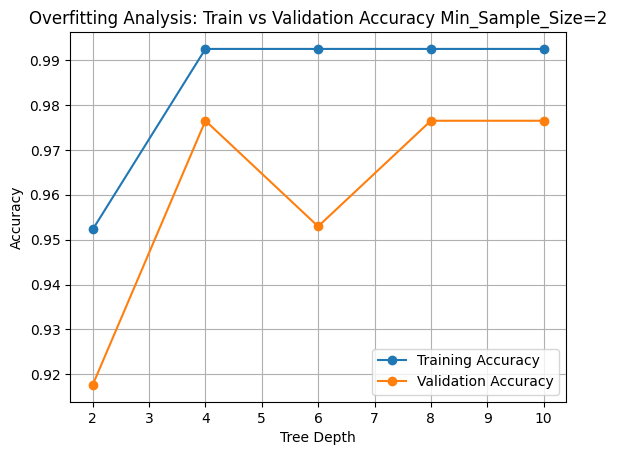

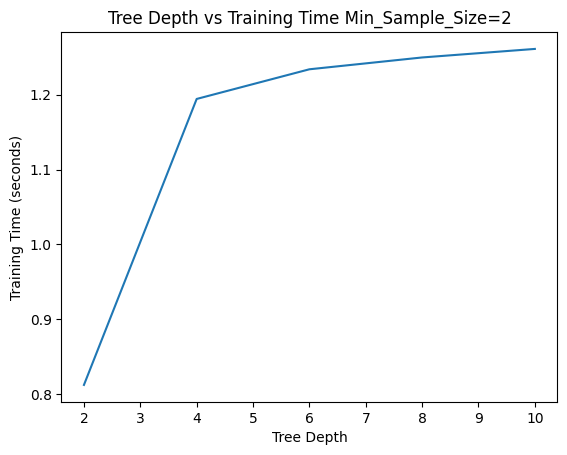

depth=2, min_split=5, train_acc=0.9523, val_acc=0.9176
depth=4, min_split=5, train_acc=0.9925, val_acc=0.9765
depth=6, min_split=5, train_acc=0.9950, val_acc=0.9529
depth=8, min_split=5, train_acc=0.9950, val_acc=0.9529
depth=10, min_split=5, train_acc=0.9950, val_acc=0.9529


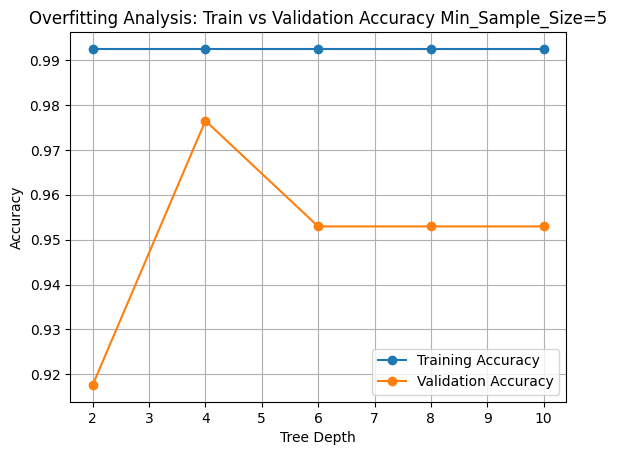

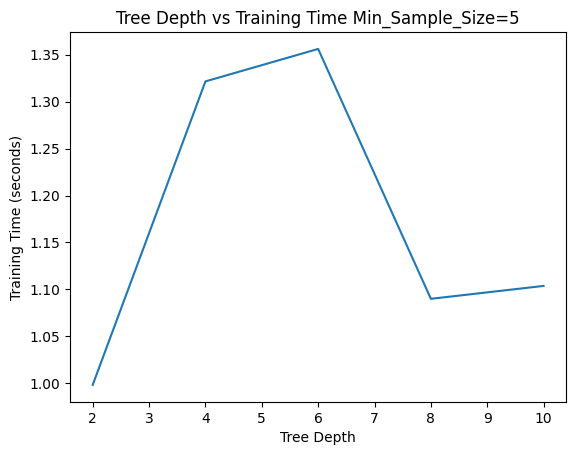

depth=2, min_split=10, train_acc=0.9523, val_acc=0.9176
depth=4, min_split=10, train_acc=0.9899, val_acc=0.9765
depth=6, min_split=10, train_acc=0.9925, val_acc=0.9529
depth=8, min_split=10, train_acc=0.9925, val_acc=0.9529
depth=10, min_split=10, train_acc=0.9925, val_acc=0.9529


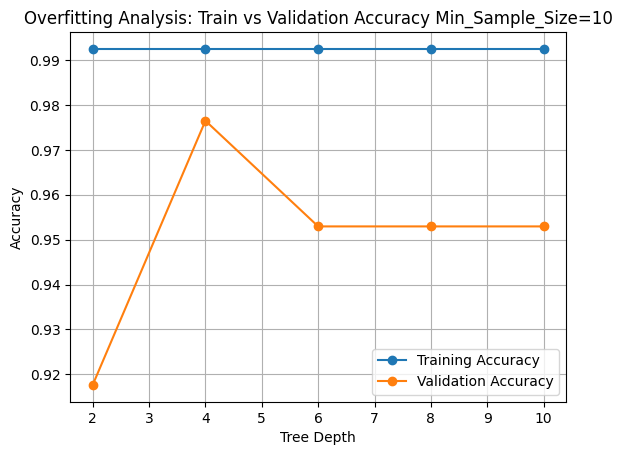

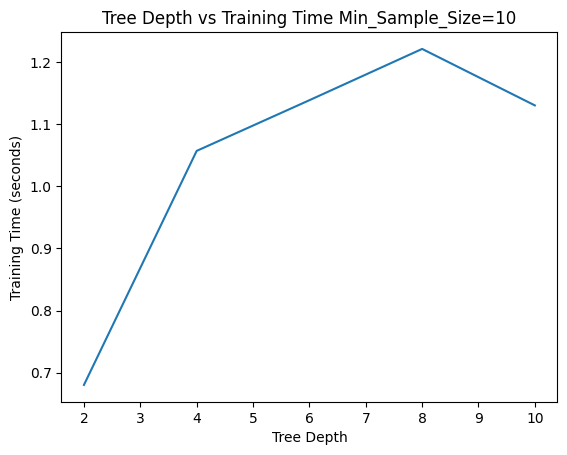

Best depth: 4, Best Minimum split: 2, Best Val ACC: 0.9765, Best Train ACC: 0.9925
Test Accuracy: 0.8837209302325582
Precision: 0.8928571428571429
Recall: 0.9259259259259259
F1-score: 0.9090909090909091
Confusion Matrix:
 [[26  6]
 [ 4 50]]
Feature Importance (feature index, total info gain):
0 0.9182958340530469
21 0.7044793212759686
22 0.5969353093394134
20 0.5549783415400575
1 0.3864828301568889
27 0.32988126478540825
23 0.22497520938859605
13 0.024947807966006465


In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import timeit
from typing import Optional
import matplotlib.pyplot as plt
from torch.ao.quantization.fx.utils import return_arg_list

def entropy(y):
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-12))

class Node:
    def __init__(self, feature=None, threshold=None, left_node=None, right_node=None, *, value=None):
        self.feature = feature        # index of feature used for split
        #Ex:
        # If height <= 175 → go left
        #Else go right
        self.feature: Optional[int] = feature       #feature column index
        self.threshold: Optional[float] = threshold # threshold value
        self.left_node: Optional["Node"] = left_node            # left child (Node)
        self.right_node: Optional["Node"] = right_node          # right child (Node)
        self.value: Optional[int]= value            # leaf output (class label)

class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None   # will hold the root node after fit()
        self.feature_importance = defaultdict(float)    # saves the IG

    def fit(self, X, y):
        #start building the tree
        self.root = self.build_tree(X, y, depth=0)

    def predict(self, X):
        #predicts y for a given X
        return np.array([self._predict_one(row, self.root) for row in X])

    def build_tree(self, X, y, depth):
        num_samples = len(y)
        num_labels = len(np.unique(y))

        # stopping condition
        if (depth >= self.max_depth or
            num_samples < self.min_samples_split or
            num_labels == 1):
            leaf_value = self.majority_class(y)
            return Node(value=leaf_value)

        # find best feature to split at
        # with the respective best splitting threshold
        best_feature, best_threshold, best_gain = self.best_split(X, y)

        if best_gain == 0:
            leaf_value = self.majority_class(y)
            return Node(value=leaf_value)

        # find row indecies of left and right
        left_idx = X[:, best_feature] <= best_threshold
        right_idx = X[:, best_feature] > best_threshold

        #we dont do this because we are working with continuous features
        #but with discrete features we do it
        #X_new = np.delete(X, best_feature, axis=1)

        left_node = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        right_node = self.build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(
            feature=best_feature, threshold=best_threshold,
            left_node=left_node, right_node=right_node
        )

    def best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None

        H_Y = entropy(y)
        n_samples, n_features = X.shape

        for feature in range(n_features):
            # Sort samples by this feature
            values = X[:, feature]
            thresholds = np.unique(values)

            # Try thresholds between unique values
            for t in thresholds:
                left_idx = values <= t
                right_idx = values > t

                if left_idx.sum() == 0 or right_idx.sum() == 0:
                    continue

                left_y = y[left_idx]
                right_y = y[right_idx]

                # Compute weighted entropy
                p_left = len(left_y) / len(y)
                #binary calssification so we can do this
                p_right = 1 - p_left
              # H(Y|X)      =     sigma p(X=x) * H(Y|X=x)
                H_Y__X = p_left * entropy(left_y) + p_right * entropy(right_y)

                info_gain = H_Y - H_Y__X

                if info_gain > best_gain:
                    best_gain = info_gain
                    best_feature = feature
                    best_threshold = t

        if best_feature is not None:
            self.feature_importance[best_feature] += best_gain

        return best_feature, best_threshold, best_gain

    def majority_class(self, y):
        #Return the class that wins the majority vote
        vals, counts = np.unique(y, return_counts=True)
        return vals[np.argmax(counts)]

    def _predict_one(self, row, node):
        #Traverse tree to return prediction for one sample
        if node.value is not None:
            return node.value
        if row[node.feature] <= node.threshold:
            return self._predict_one(row, node.left_node)
        else:
            return self._predict_one(row, node.right_node)

if __name__ == "__main__":
    timer = timeit.default_timer
    data = load_breast_cancer()
    X = data.data
    y = data.target

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
    )

    # Show sizes
    print("Train:", X_train.shape)
    print("Val:", X_val.shape)
    print("Test:", X_test.shape)

    max_depth_list = [2, 4, 6, 8, 10]
    min_samples_list = [2, 5, 10]

    best_val_acc = -1
    train_acc_of_best_val_acc = -1
    val_acc = -1
    best_params = None
    for min_s in min_samples_list:
        train_accs = []
        val_accs = []
        train_times = []
        for depth in max_depth_list:
            start = timer()
            tree = DecisionTree(max_depth=depth, min_samples_split=min_s)
            tree.fit(X_train, y_train)
            train_preds = tree.predict(X_train)
            val_preds = tree.predict(X_val)
            end = timer()
            train_acc = np.mean(train_preds == y_train)
            val_acc = np.mean(val_preds == y_val)
            print(f"depth={depth}, min_split={min_s}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                train_acc_of_best_val_acc = train_acc
                best_params = (depth, min_s)
            train_accs.append(train_acc_of_best_val_acc)
            val_accs.append(val_acc)
            train_times.append(end - start)
        # Accuracy vs Depth
        plt.figure()
        plt.plot(max_depth_list, train_accs, marker='o')
        plt.plot(max_depth_list, val_accs, marker='o')
        plt.xlabel("Tree Depth")
        plt.ylabel("Accuracy")
        plt.title(f"Overfitting Analysis: Train vs Validation Accuracy Min_Sample_Size={min_s}")
        plt.legend(["Training Accuracy", "Validation Accuracy"])
        plt.grid(True)
        plt.show(block=False)
        plt.pause(0.1)  # short pause to render the figure
        # Time vs Depth
        plt.figure()
        plt.plot(max_depth_list, train_times)
        plt.xlabel("Tree Depth")
        plt.ylabel("Training Time (seconds)")
        plt.title(f"Tree Depth vs Training Time Min_Sample_Size={min_s}")
        plt.show(block=False)
        plt.pause(0.1)  # short pause to render the figure


    print(f"Best depth: {best_params[0]}, Best Minimum split: {best_params[1]}, Best Val ACC: {best_val_acc:.4f}, Best Train ACC: {train_acc_of_best_val_acc:.4f}")

    best_depth, best_min_samples = best_params

    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)

    final_tree = DecisionTree(max_depth=best_depth,
                              min_samples_split=best_min_samples)

    final_tree.fit(X_trainval, y_trainval)

    y_pred = final_tree.predict(X_test)
    test_acc = np.mean(y_pred == y_test)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print("Test Accuracy:", test_acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    print("Confusion Matrix:\n", cm)

    sorted_features = sorted(final_tree.feature_importance.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importance (feature index, total info gain):")
    for f, score in sorted_features:
        print(f, score)

    input("Press enter to Exit")

